<a href="https://colab.research.google.com/github/PacoPacorius/MedMNIST-Image-Analysis-w-CNNs-and-Transformers---DL-assignment/blob/master/deep_learning_assignment_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 7.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator, ChestMNIST
import random




# set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f"All random seeds set to {seed}")


info = INFO['chestmnist']['label']
print(info)

All random seeds set to 42
{'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}


In [ ]:
# Create DataLoaders
batch_size = 64
#num_workers = 2

download=True
# define non-normalized dataset and dataloader
train_dataset = medmnist.ChestMNIST(split='train', download=download, transform=transforms.ToTensor())
val_dataset = medmnist.ChestMNIST(split='val', download=download, transform=transforms.ToTensor())
test_dataset = medmnist.ChestMNIST(split='test', download=download, transform=transforms.ToTensor())


train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# confirm that the numbers on medmnist's site are accurate
print(f"--- Dataset: ChestMNIST ---")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print("-" * 40)
print(f"DataLoaders created with batch_size={batch_size}")
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")

100%|██████████| 82.8M/82.8M [01:15<00:00, 1.10MB/s]


--- Dataset: ChestMNIST ---
Number of training images: 78468
Number of validation images: 11219
Number of test images: 22433
----------------------------------------
DataLoaders created with batch_size=64
Train DataLoader: 1227 batches
Validation DataLoader: 176 batches
Test DataLoader: 351 batches



Number of images tagged with each class (across Train + Val + Test sets):
- 0                   : 11535 images
- 1                   : 2772 images
- 2                   : 13307 images
- 3                   : 19870 images
- 4                   : 5746 images
- 5                   : 6323 images
- 6                   : 1353 images
- 7                   : 5298 images
- 8                   : 4667 images
- 9                   : 2303 images
- 10                  : 2516 images
- 11                  : 1686 images
- 12                  : 3385 images
- 13                  : 227 images

Note: ChestMNIST is a multi-label dataset, meaning one image can be associated with multiple classes.
The counts above reflect the total occurrences of each tag.

--- Optional: Counts for Training Set Only ---
- 0                   : 7996 images
- 1                   : 1950 images
- 2                   : 9261 images
- 3                   : 13914 images
- 4                   : 3988 images
- 5                   : 437

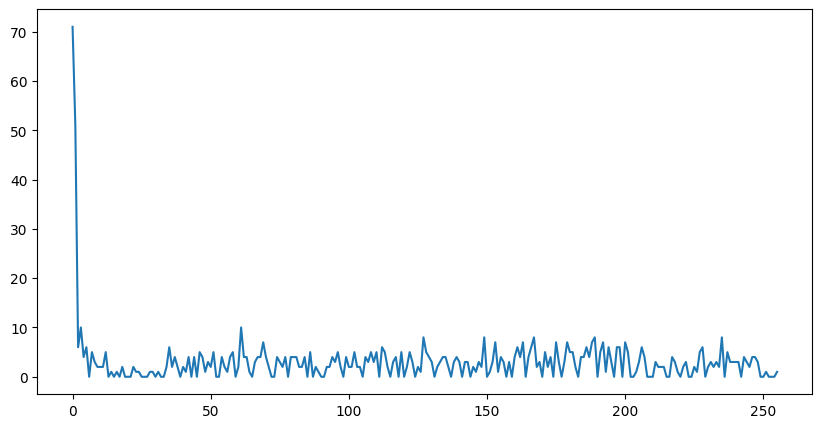

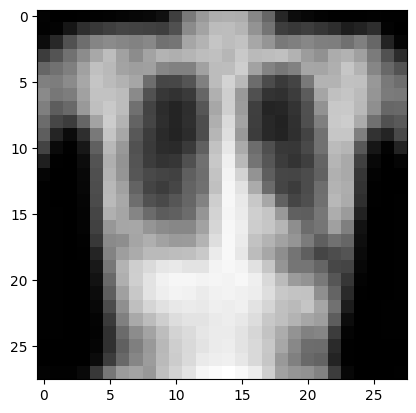

In [ ]:
# --- count images per class ---

def count_medmnist_labels(dataset_list, info):
    all_labels = []
    label_names = []
    for dataset in dataset_list:
        # Each dataset.labels is a numpy array where rows are images
        # and columns correspond to the 14 classes (0 for absence, 1 for presence)
        all_labels.append(dataset.labels)

    # Concatenate all label arrays vertically to get one big array of all labels
    combined_labels = np.vstack(all_labels)

    # Sum along the columns to get the total count for each class across all images.
    # Since labels are 0s and 1s, sum gives the number of images tagged with that class.
    class_counts = combined_labels.sum(axis=0)
    label_names.extend(info)


    # Create a dictionary for easier readability
    counts_dict = {name: int(count) for name, count in zip(label_names, class_counts)}
    return counts_dict

# Perform the counting on the combined training, validation, and test sets
all_datasets = [train_dataset, val_dataset, test_dataset]
label_counts = count_medmnist_labels(all_datasets, info)

print("\nNumber of images tagged with each class (across Train + Val + Test sets):")
for class_name, count in label_counts.items():
    print(f"- {class_name:<20}: {count} images")
print("\nNote: ChestMNIST is a multi-label dataset, meaning one image can be associated with multiple classes.")
print("The counts above reflect the total occurrences of each tag.")

# --- count for just the training set ---
print("\n--- Optional: Counts for Training Set Only ---")
train_label_counts = count_medmnist_labels([train_dataset], info)
for class_name, count in train_label_counts.items():
    print(f"- {class_name:<20}: {count} images")

# RGB or grayscale image? separate the image data from the label data
img, _ = val_dataset[0]
print(f"Shape of sample image: {img.numpy().shape}")


# histogram and corresponding image plot just for fun :)
import matplotlib.pyplot as plt
figure, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.histogram(img.numpy(), 256)[0])
plt.show()
plt.imshow(img.numpy().reshape((28,28)), cmap='gray')



In [ ]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data

# Create a temporary DataLoader for calculating mean and std
# Use a batch size that fits memory, as we need to iterate over all images
temp_loader = data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=False)

mean = 0.
std = 0.
nb_samples = 0.

for data_batch, _ in temp_loader:
    batch_samples = data_batch.size(0)
    data_batch = data_batch.view(batch_samples, data_batch.size(1), -1)
    mean += data_batch.mean(2).sum(0)
    std += data_batch.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Calculated Mean of Training Data: {mean.item():.4f}")
print(f"Calculated Standard Deviation of Training Data: {std.item():.4f}")

# Define data_transform_normalized using the calculated mean and std
data_transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Define data_transform_non_normalized (only ToTensor)
data_transform_non_normalized = transforms.Compose([
    transforms.ToTensor()
])

print("Defined data_transform_normalized and data_transform_non_normalized successfully.")

Calculated Mean of Training Data: 0.4936
Calculated Standard Deviation of Training Data: 0.2170
Defined data_transform_normalized and data_transform_non_normalized successfully.


In [ ]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, normalization_type=None, dropout_rate=None):
        super(SimpleCNN, self).__init__()
        self.normalization_type = normalization_type
        self.dropout_rate = dropout_rate

        # Convolutional Block 1
        # Input: 1 channel (grayscale), Output: 32 channels. Image size: 28x28 -> 28x28 (padding=1)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # After Conv1: (N, 32, 28, 28)
        self.norm1 = self._get_normalization_layer(32, (28, 28))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # After MaxPool1: (N, 32, 14, 14)

        # Convolutional Block 2
        # Input: 32 channels, Output: 64 channels. Image size: 14x14 -> 14x14 (padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # After Conv2: (N, 64, 14, 14)
        self.norm2 = self._get_normalization_layer(64, (14, 14))

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # After MaxPool2: (N, 64, 7, 7)

        # Convolutional Block 3
        # Input: 64 channels, Output: 128 channels. Image size: 7x7 -> 7x7 (padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # After Conv3: (N, 128, 7, 7)
        self.norm3 = self._get_normalization_layer(128, (7, 7))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # After MaxPool3: (N, 128, 3, 3) (floor(7/2) = 3)

        self.relu = nn.ReLU()

        # Dropout layer (applied before final FC layer)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate is not None else None

        # Fully connected layer
        # Input features: 128 channels * 3x3 spatial dimension
        # Output classes: 14 for ChestMNIST
        self.fc = nn.Linear(128 * 3 * 3, 14)

    def _get_normalization_layer(self, num_features, spatial_dim):
        if self.normalization_type == 'batchnorm':
            return nn.BatchNorm2d(num_features)
        elif self.normalization_type == 'layernorm':
            # LayerNorm normalizes across the last D dimensions, here (C, H, W)
            return nn.LayerNorm([num_features, spatial_dim[0], spatial_dim[1]])
        return None # No normalization

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        if self.norm1:
            x = self.norm1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Block 2
        x = self.conv2(x)
        if self.norm2:
            x = self.norm2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Block 3
        x = self.conv3(x)
        if self.norm3:
            x = self.norm3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Flatten output for the fully connected layer
        x = torch.flatten(x, 1)

        # Apply dropout if enabled
        if self.dropout:
            x = self.dropout(x)

        # Final fully connected layer
        x = self.fc(x)
        return x

print("SimpleCNN class defined successfully.")

SimpleCNN class defined successfully.


In [ ]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# train function for one epoch
def train_one_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float() # Labels must be float for BCEWithLogitsLoss

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # For multi-label accuracy calculation
        predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.numel()

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    return epoch_loss, epoch_accuracy

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.numel()

    avg_loss = running_loss / len(data_loader.dataset)
    avg_accuracy = correct_predictions / total_predictions
    return avg_loss, avg_accuracy

def test_model(model, data_loader, device, class_names):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()

            all_labels.append(labels.cpu().numpy())
            all_predictions.append(predicted_labels.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)

    # Calculate overall accuracy (mean accuracy across all labels and samples)
    overall_accuracy = (all_predictions == all_labels).mean()

    # calulcate confusion matrices function
    def calculate_confusion_matrices(all_labels, all_predictions, num_classes):
      per_class_cms = []

      for i in range(num_classes):
          # Extract true and predicted labels for the current class 'i'
          true_labels_class_i = all_labels[:, i]
          predicted_labels_class_i = all_predictions[:, i]

          # Initialize counts for the current class
          tp = 0  # True Positives
          tn = 0  # True Negatives
          fp = 0  # False Positives
          fn = 0  # False Negatives

          # Iterate through each sample to fill the confusion matrix
          for j in range(len(true_labels_class_i)):
              true_val = true_labels_class_i[j]
              pred_val = predicted_labels_class_i[j]

              if true_val == 1 and pred_val == 1: # Actual is 1, Predicted is 1
                  tp += 1
              elif true_val == 0 and pred_val == 0: # Actual is 0, Predicted is 0
                  tn += 1
              elif true_val == 0 and pred_val == 1: # Actual is 0, Predicted is 1
                  fp += 1
              elif true_val == 1 and pred_val == 0: # Actual is 1, Predicted is 0
                  fn += 1

          # Form the 2x2 confusion matrix for the current class
          # [[TN, FP],
          #  [FN, TP]]
          cm = np.array([[tn, fp],
                                [fn, tp]])
          per_class_cms.append(cm)

      return per_class_cms


    # calculate per-class confusion matrices using respective function
    num_classes = all_labels.shape[1]
    per_class_cms = []
    per_class_cms = calculate_confusion_matrices(all_labels, all_predictions, num_classes)

    return overall_accuracy, per_class_cms

print("Training, evaluation, and testing functions defined successfully.")

Using device: cuda
Training, evaluation, and testing functions defined successfully.


In [ ]:
hyperparameter_combinations = [
    {'normalization': None, 'dropout': None, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': None, 'dropout': None, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': 'batchnorm', 'dropout': None, 'weight_decay': None, 'learning_rate': 5e-4, 'input_normalization': False},
    {'normalization': 'layernorm', 'dropout': None, 'weight_decay': None, 'learning_rate': 5e-4, 'input_normalization': False},
    {'normalization': None, 'dropout': 0.5, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': None, 'dropout': 0.7, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': 'batchnorm', 'dropout': 0.5, 'weight_decay': None, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': 'batchnorm', 'dropout': 0.7, 'weight_decay': None, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': None, 'dropout': None, 'weight_decay': 1e-4, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': None, 'dropout': None, 'weight_decay': 1e-3, 'learning_rate': 1e-3, 'input_normalization': False},
    {'normalization': 'batchnorm', 'dropout': None, 'weight_decay': 1e-4, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': 'batchnorm', 'dropout': None, 'weight_decay': 1e-3, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': None, 'dropout': 0.7, 'weight_decay': 1e-4, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': None, 'dropout': 0.7, 'weight_decay': 1e-3, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': 'batchnorm', 'dropout': 0.7, 'weight_decay': 1e-4, 'learning_rate': 1e-4, 'input_normalization': False},
    {'normalization': 'batchnorm', 'dropout': 0.7, 'weight_decay': 1e-3, 'learning_rate': 1e-4, 'input_normalization': False}



]

"""
 {'normalization': None, 'dropout': None, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': True},
  {'normalization': 'batchnorm', 'dropout': None, 'weight_decay': None, 'learning_rate': 5e-4, 'input_normalization': True},
  {'normalization': 'layernorm', 'dropout': None, 'weight_decay': None, 'learning_rate': 5e-4, 'input_normalization': True},
  {'normalization': None, 'dropout': 0.5, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': True},
  {'normalization': None, 'dropout': 0.7, 'weight_decay': None, 'learning_rate': 1e-3, 'input_normalization': True},
  {'normalization': 'batchnorm', 'dropout': 0.5, 'weight_decay': None, 'learning_rate': 1e-4, 'input_normalization': True},
  {'normalization': 'batchnorm', 'dropout': 0.7, 'weight_decay': None, 'learning_rate': 1e-4, 'input_normalization': True},
  {'normalization': None, 'dropout': None, 'weight_decay': 1e-4, 'learning_rate': 1e-3, 'input_normalization': True},
  {'normalization': None, 'dropout': None, 'weight_decay': 1e-3, 'learning_rate': 1e-3, 'input_normalization': True},
  {'normalization': 'batchnorm', 'dropout': None, 'weight_decay': 1e-4, 'learning_rate': 1e-4, 'input_normalization': True},
  {'normalization': 'batchnorm', 'dropout': None, 'weight_decay': 1e-3, 'learning_rate': 1e-4, 'input_normalization': True},
  {'normalization': None, 'dropout': 0.7, 'weight_decay': 1e-4, 'learning_rate': 1e-4, 'input_normalization': True},
  {'normalization': None, 'dropout': 0.7, 'weight_decay': 1e-3, 'learning_rate': 1e-4, 'input_normalization': True},
  {'normalization': 'batchnorm', 'dropout': 0.7, 'weight_decay': 1e-4, 'learning_rate': 1e-4, 'input_normalization': True},
  {'normalization': 'batchnorm', 'dropout': 0.7, 'weight_decay': 1e-3, 'learning_rate': 1e-4, 'input_normalization': True}

  # Test the same hyperparameters with input normalization

  """

print(f"Generated {len(hyperparameter_combinations)} updated hyperparameter combinations.")

Generated 16 updated hyperparameter combinations.


In [ ]:
num_epochs = 30

# Initialize an empty list to store results for all combinations
all_results = []

# Get class names from info dictionary for confusion matrix plotting later
class_names = list(info.keys())

best_val_accuracy = -1
best_hyperparameters = None
best_model_state_dict = None

for i, combo in enumerate(hyperparameter_combinations):
    print(f"\n--- Evaluating Combination {i+1}/{len(hyperparameter_combinations)} ---")
    print(f"Hyperparameters: {combo}")

    # Select data transformation based on 'input_normalization'
    if combo['input_normalization']:
        current_data_transform = data_transform_normalized
    else:
        current_data_transform = data_transform_non_normalized

    # Create new datasets with the selected transformation
    train_dataset_transformed = medmnist.ChestMNIST(split='train', download=download, transform=current_data_transform)
    val_dataset_transformed = medmnist.ChestMNIST(split='val', download=download, transform=current_data_transform)


    # Create DataLoaders for the current combination
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset_transformed, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset_transformed, batch_size=batch_size, shuffle=False)



    # Instantiate model with current hyperparameters
    model = SimpleCNN(
        normalization_type=combo['normalization'],
        dropout_rate=combo['dropout']
    ).to(device)

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=combo['learning_rate'],
        weight_decay=combo['weight_decay'] if combo['weight_decay'] is not None else 0
    )

    # Initialize lists to store metrics for the current model
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    current_best_val_acc_for_combo = -1
    current_best_model_state_dict_for_combo = None # Added to store best model state for current combo

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Track best model based on validation accuracy during this combo's training
        if val_acc > current_best_val_acc_for_combo:
            current_best_val_acc_for_combo = val_acc
            # Save the model state_dict for this combo's best performance
            current_best_model_state_dict_for_combo = model.state_dict()

    # Store results for the current combination (without test metrics)
    all_results.append({
        'hyperparameters': combo,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_accuracy_for_combo': current_best_val_acc_for_combo
    })

    # After all epochs for the current combo, check if this model is the overall best
    if current_best_val_acc_for_combo > best_val_accuracy:
        best_val_accuracy = current_best_val_acc_for_combo
        best_hyperparameters = combo
        # Use the state_dict that corresponds to the best performance for this combo
        best_model_state_dict = current_best_model_state_dict_for_combo

print("\nAll hyperparameter combinations evaluated. Results stored in 'all_results' list.")
print(f"Best Validation Accuracy Found: {best_val_accuracy:.4f} with Hyperparameters: {best_hyperparameters}")


--- Evaluating Combination 1/16 ---
Hyperparameters: {'normalization': None, 'dropout': None, 'weight_decay': None, 'learning_rate': 0.001, 'input_normalization': False}
Epoch 1/30: Train Loss: 0.1807, Train Acc: 0.9482 | Val Loss: 0.1740, Val Acc: 0.9492
Epoch 2/30: Train Loss: 0.1727, Train Acc: 0.9485 | Val Loss: 0.1685, Val Acc: 0.9492
Epoch 3/30: Train Loss: 0.1693, Train Acc: 0.9485 | Val Loss: 0.1669, Val Acc: 0.9492
Epoch 4/30: Train Loss: 0.1671, Train Acc: 0.9486 | Val Loss: 0.1655, Val Acc: 0.9490
Epoch 5/30: Train Loss: 0.1652, Train Acc: 0.9486 | Val Loss: 0.1644, Val Acc: 0.9491
Epoch 6/30: Train Loss: 0.1634, Train Acc: 0.9488 | Val Loss: 0.1643, Val Acc: 0.9492
Epoch 7/30: Train Loss: 0.1620, Train Acc: 0.9488 | Val Loss: 0.1635, Val Acc: 0.9492
Epoch 8/30: Train Loss: 0.1605, Train Acc: 0.9490 | Val Loss: 0.1643, Val Acc: 0.9482
Epoch 9/30: Train Loss: 0.1591, Train Acc: 0.9491 | Val Loss: 0.1637, Val Acc: 0.9489
Epoch 10/30: Train Loss: 0.1578, Train Acc: 0.9492 | Va

In [ ]:

import torchvision.transforms as transforms

# Instantiate the best model with the best hyperparameters  -- do this manually
best_model = SimpleCNN(
    normalization_type=best_hyperparameters['normalization'],
    dropout_rate=best_hyperparameters['dropout']
).to(device)

print(f"Testing the final best model with hyperparameters: {best_hyperparameters}")

# Load the state dictionary of the best performing model
best_model.load_state_dict(best_model_state_dict)

# Prepare the test dataset with the input normalization used by the best model
if best_hyperparameters['input_normalization']:
    final_test_transform = data_transform_normalized
else:
    final_test_transform = data_transform_non_normalized

# Create a new test dataset and DataLoader for the best model
final_test_dataset = medmnist.ChestMNIST(split='test', download=download, transform=final_test_transform)
final_test_loader = torch.utils.data.DataLoader(dataset=final_test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the best model on the test set
final_test_accuracy, final_per_class_cms = test_model(best_model, final_test_loader, device, class_names)

print(f"\nFinal Test Overall Accuracy: {final_test_accuracy:.4f}")
print("\nPer-Class Confusion Matrices on Test Set:")

# Print each confusion matrix
for i, cm in enumerate(final_per_class_cms):
    class_name = info[str(i)] # Get class name from the info dictionary
    print(f"\nConfusion Matrix for Class '{class_name}' ({i}):")
    print(cm)
    print(f"  True Positives (TP): {cm[1, 1]}")
    print(f"  True Negatives (TN): {cm[0, 0]}")
    print(f"  False Positives (FP): {cm[0, 1]}")
    print(f"  False Negatives (FN): {cm[1, 0]}")

Testing the final best model with hyperparameters: {'normalization': None, 'dropout': 0.7, 'weight_decay': None, 'learning_rate': 0.001, 'input_normalization': False}

Final Test Overall Accuracy: 0.9478

Per-Class Confusion Matrices on Test Set:

Confusion Matrix for Class 'atelectasis' (0):
[[20000    13]
 [ 2402    18]]
  True Positives (TP): 18
  True Negatives (TN): 20000
  False Positives (FP): 13
  False Negatives (FN): 2402

Confusion Matrix for Class 'cardiomegaly' (1):
[[21836    15]
 [  561    21]]
  True Positives (TP): 21
  True Negatives (TN): 21836
  False Positives (FP): 15
  False Negatives (FN): 561

Confusion Matrix for Class 'effusion' (2):
[[19508   171]
 [ 2457   297]]
  True Positives (TP): 297
  True Negatives (TN): 19508
  False Positives (FP): 171
  False Negatives (FN): 2457

Confusion Matrix for Class 'infiltration' (3):
[[18449    46]
 [ 3899    39]]
  True Positives (TP): 39
  True Negatives (TN): 18449
  False Positives (FP): 46
  False Negatives (FN): 38

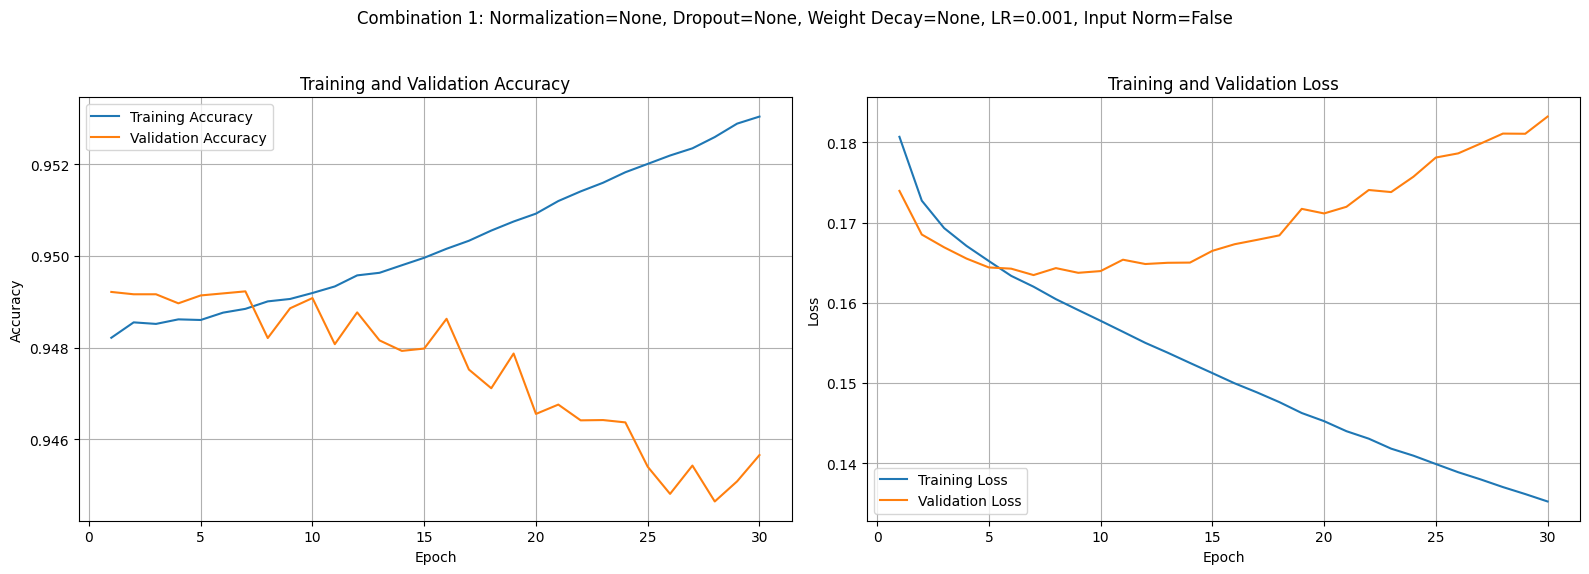

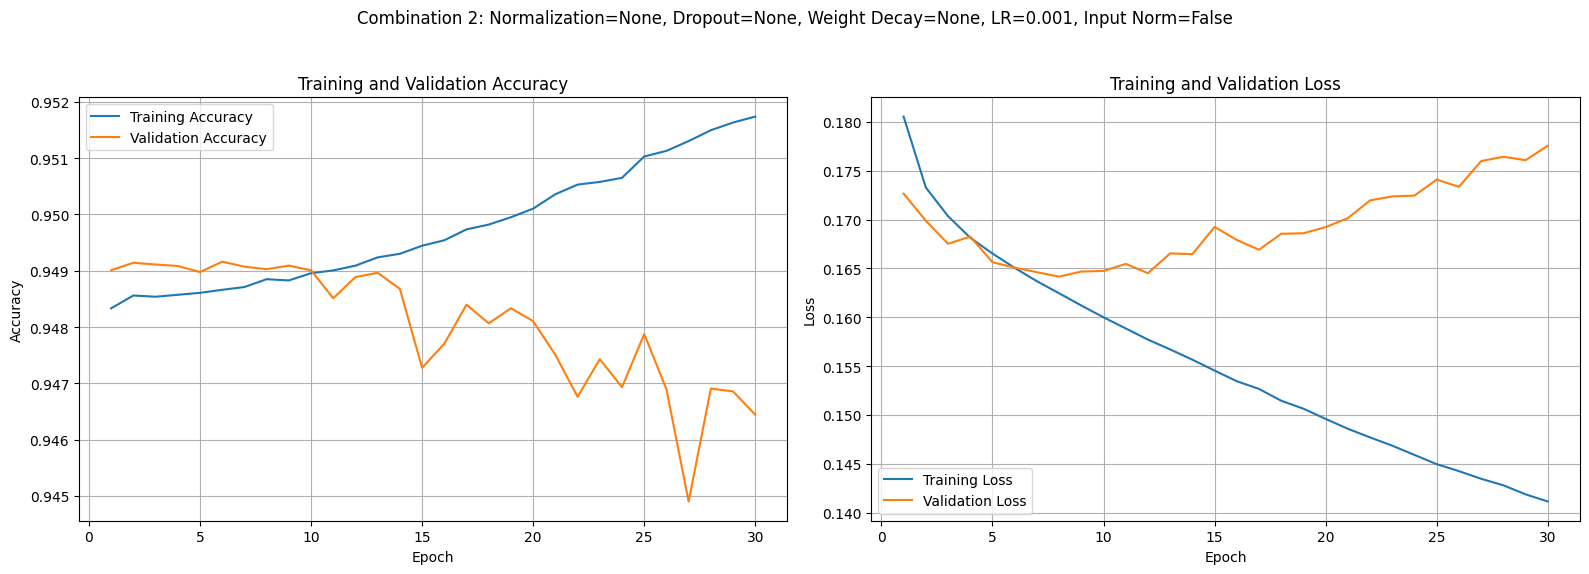

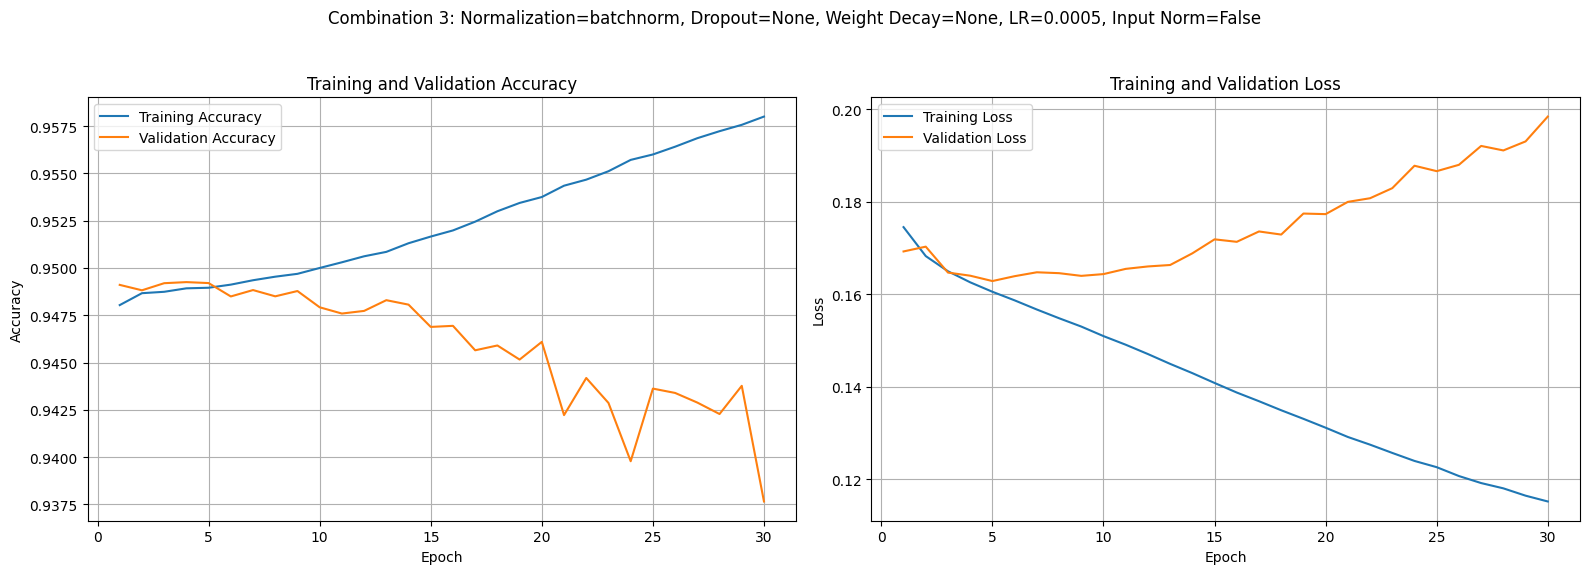

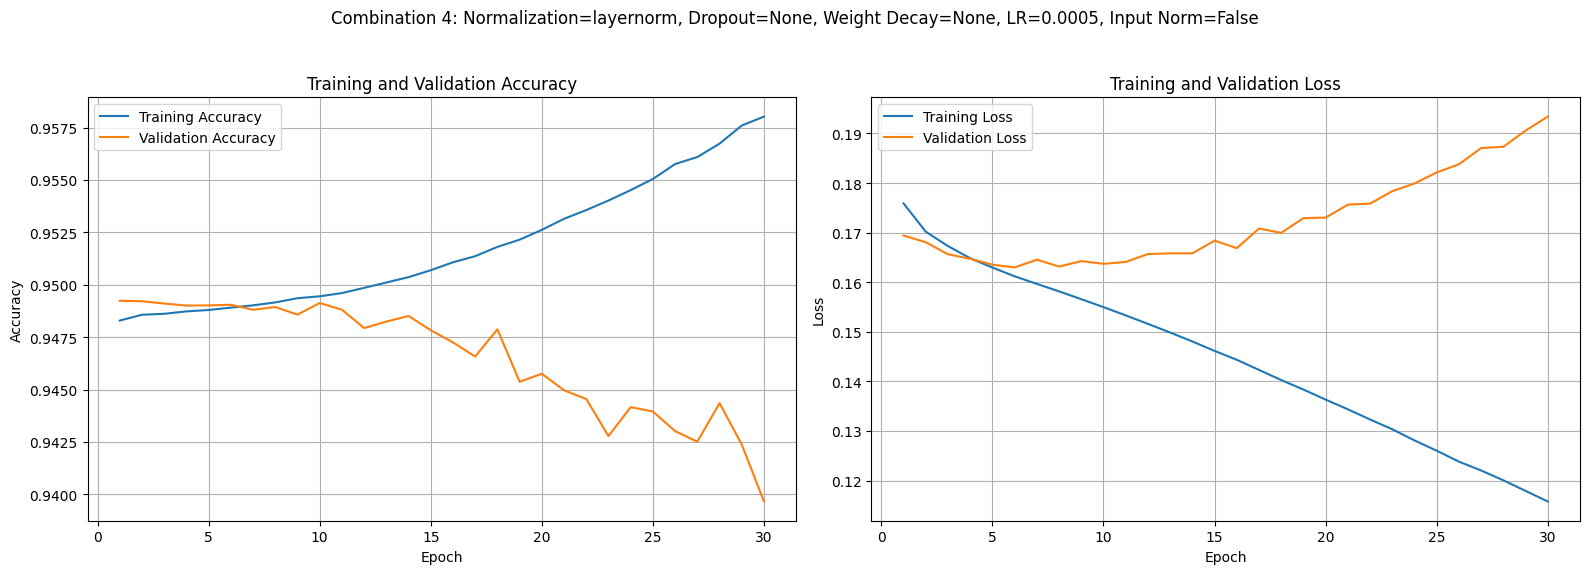

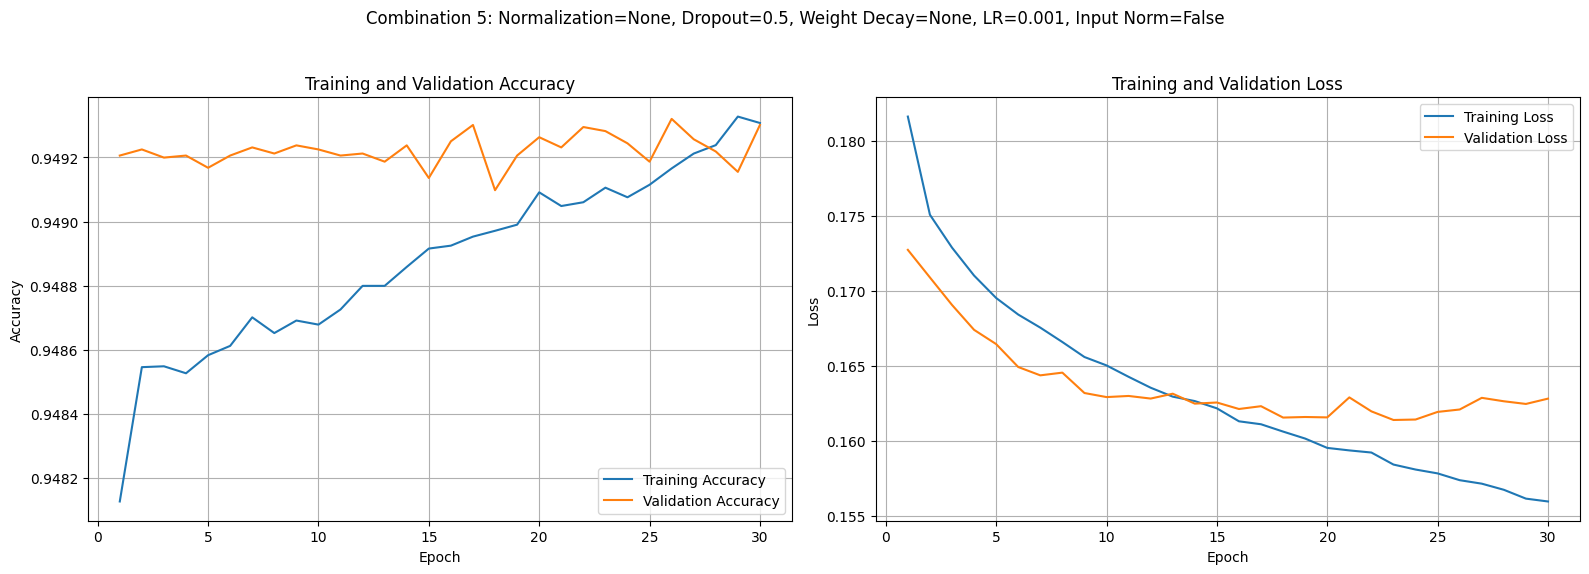

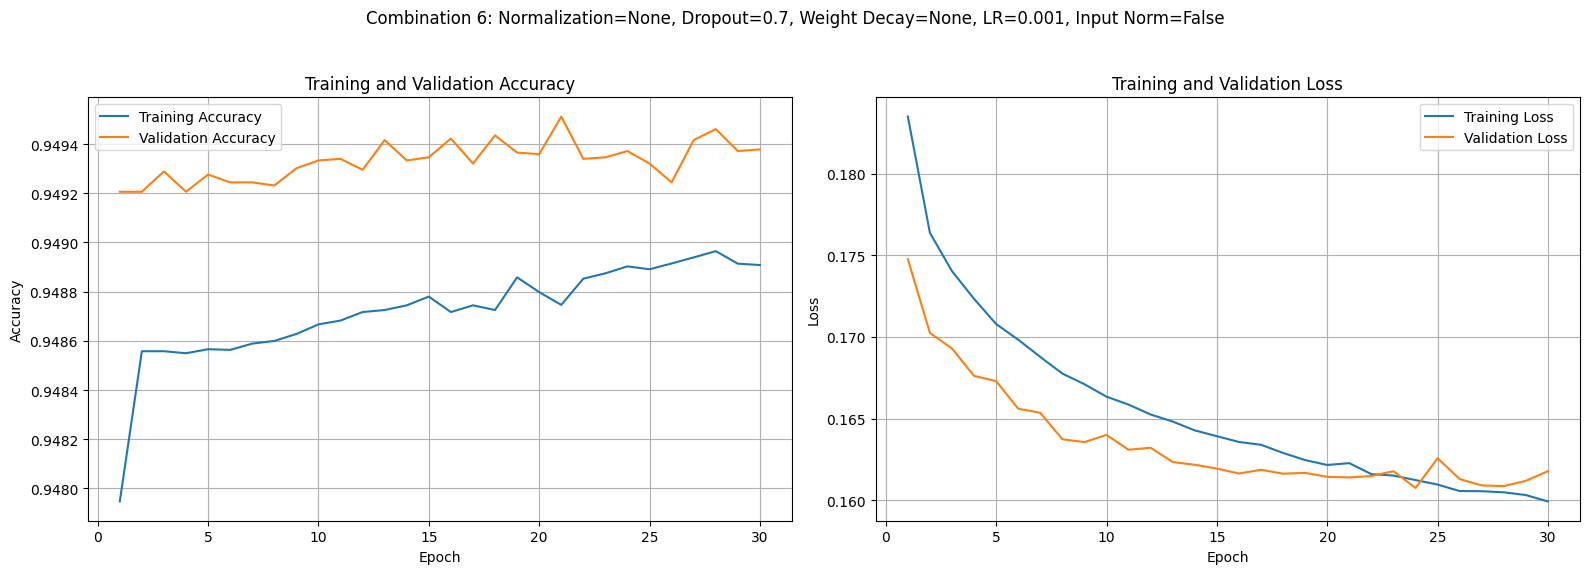

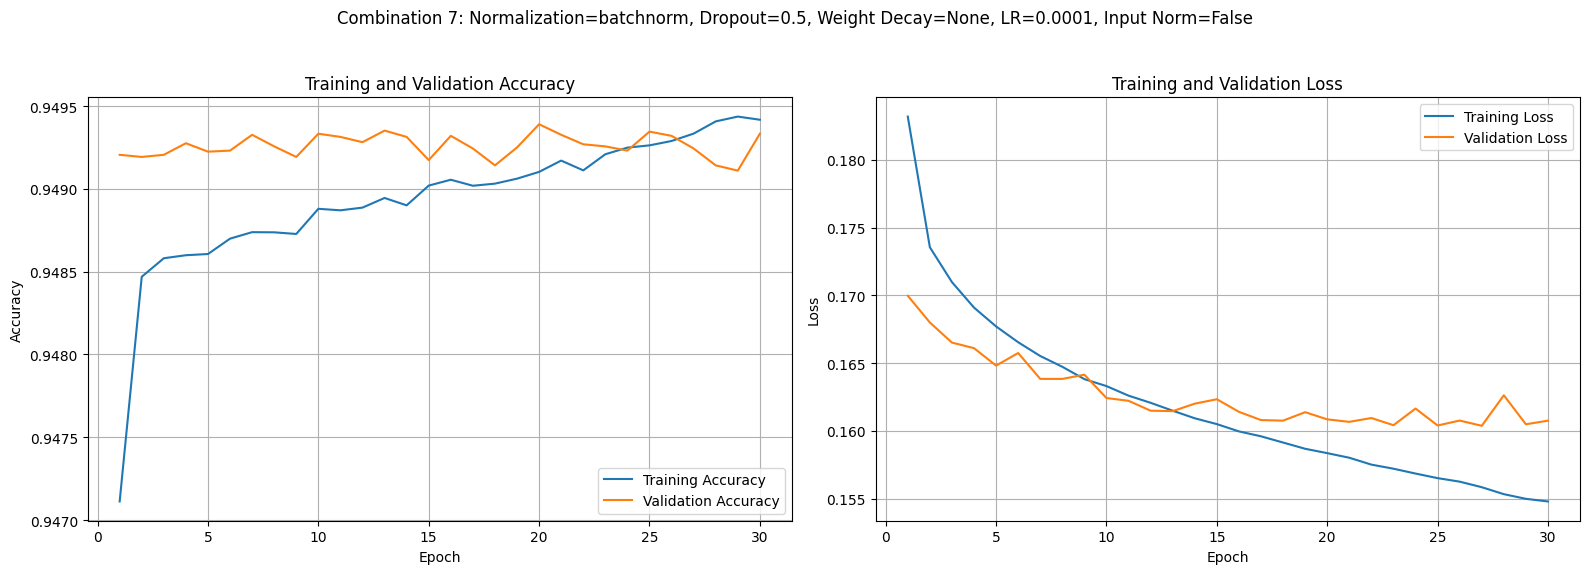

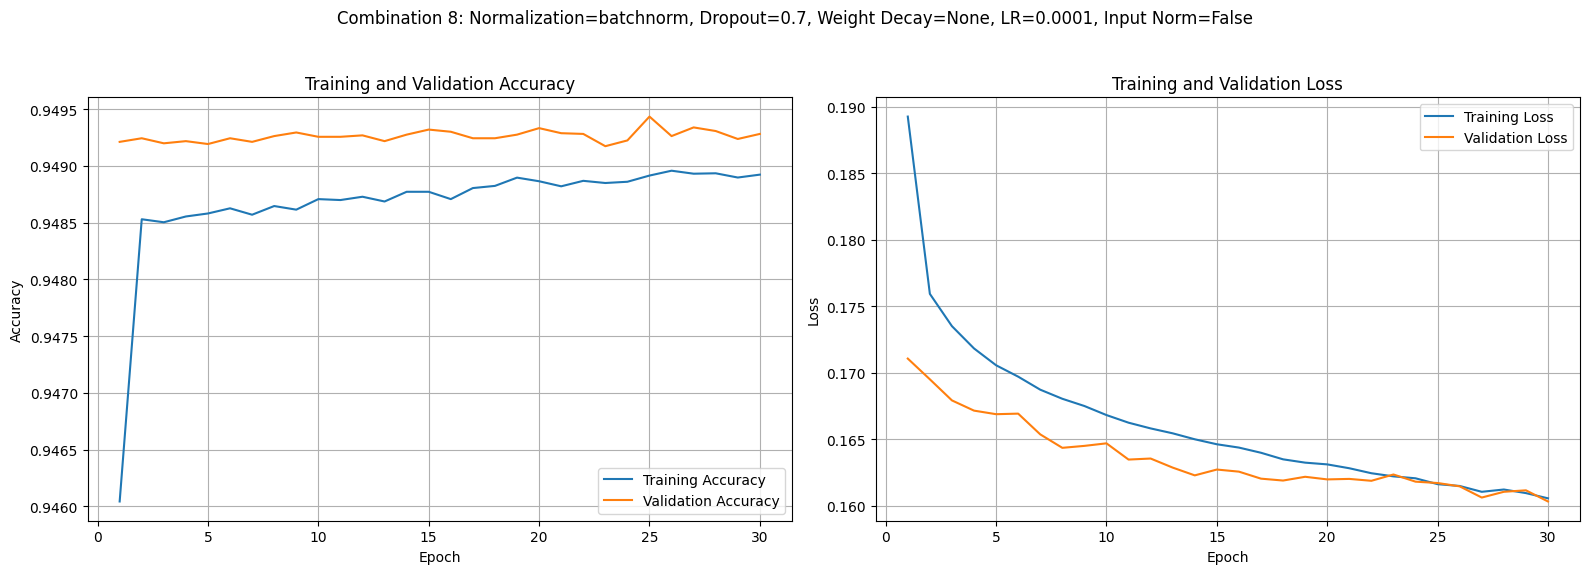

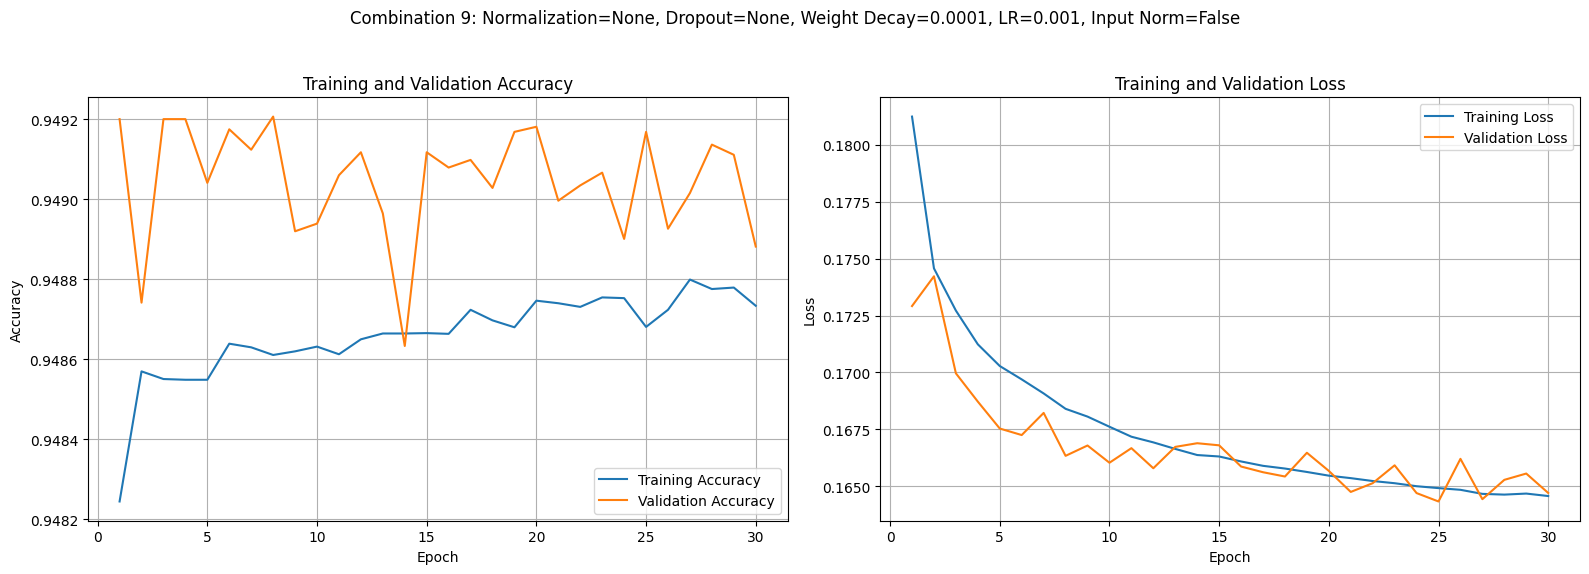

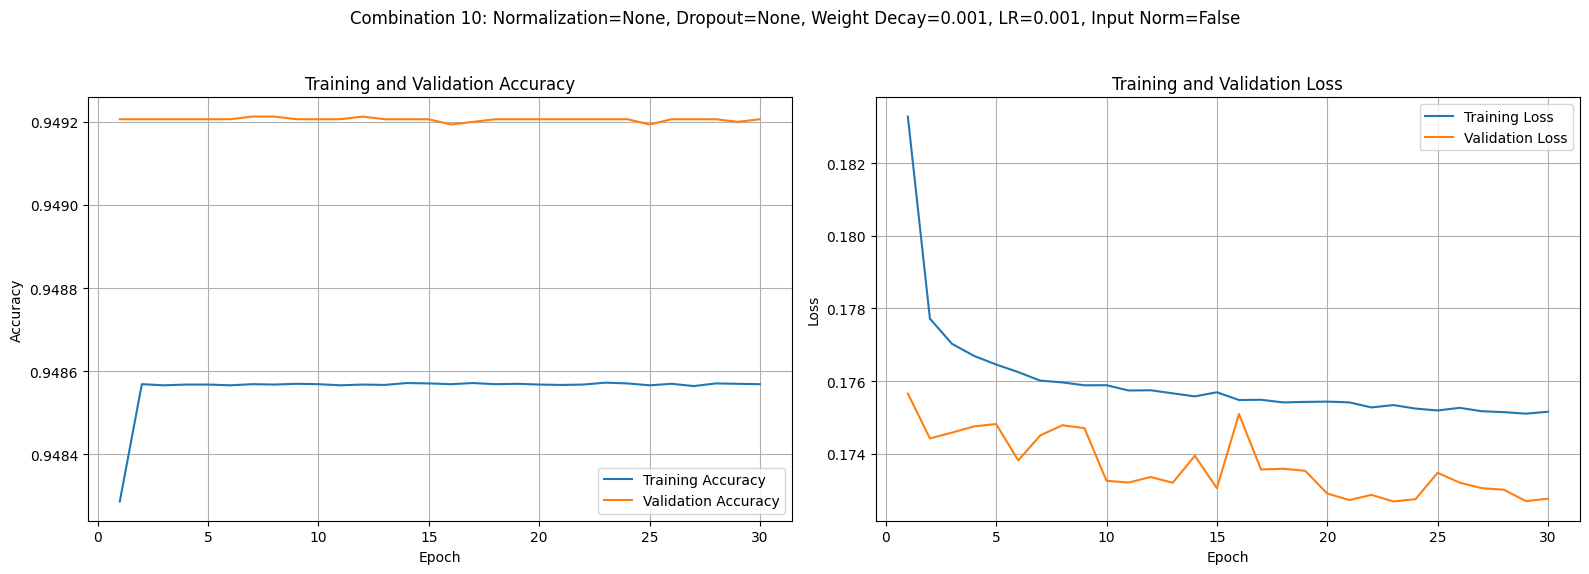

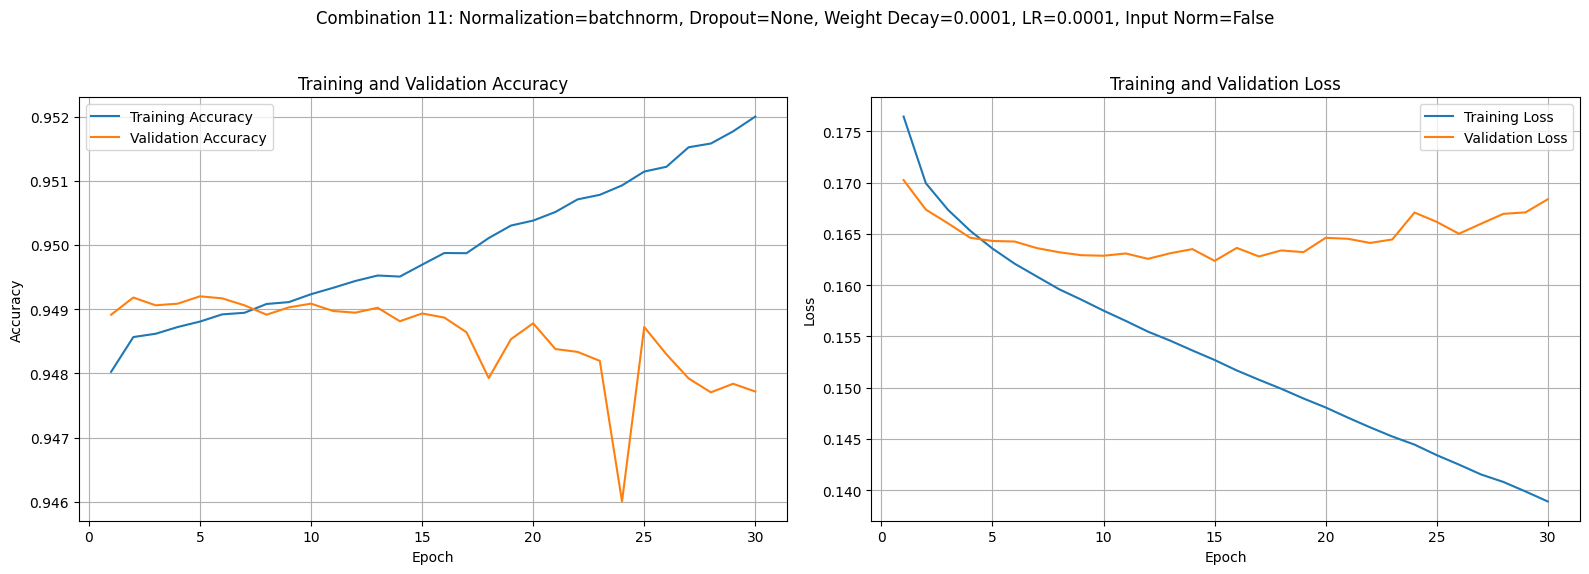

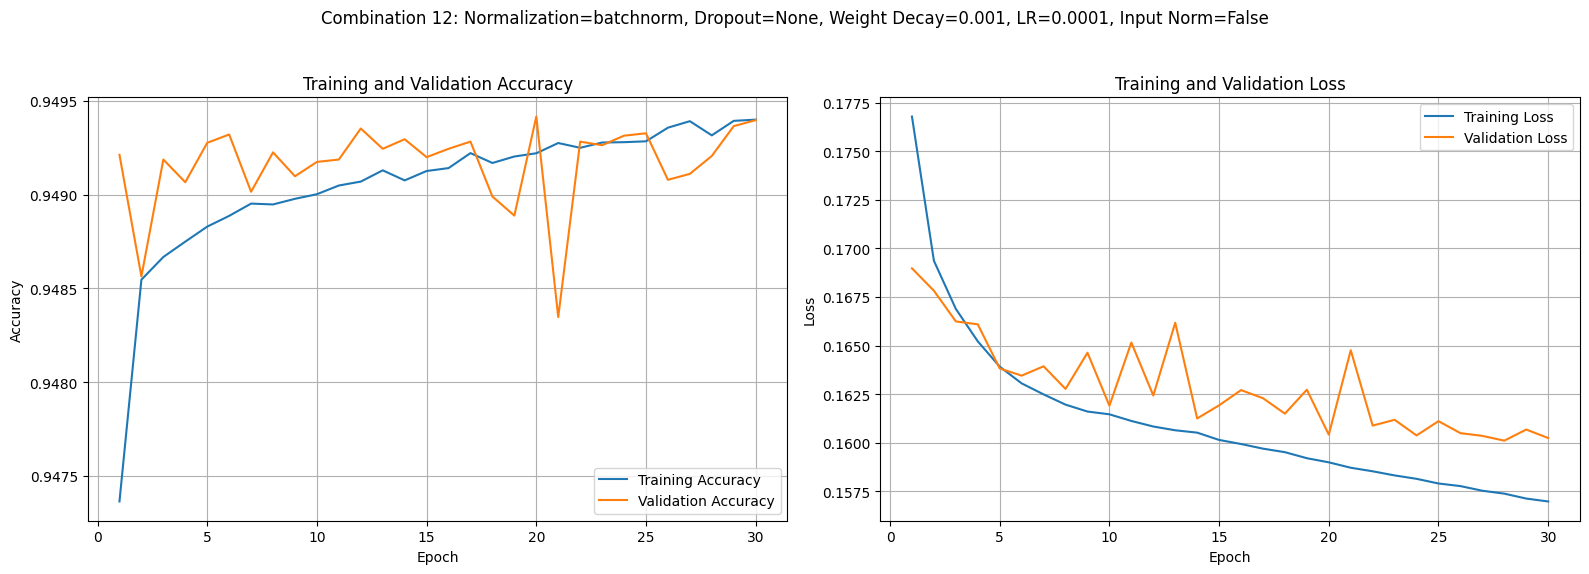

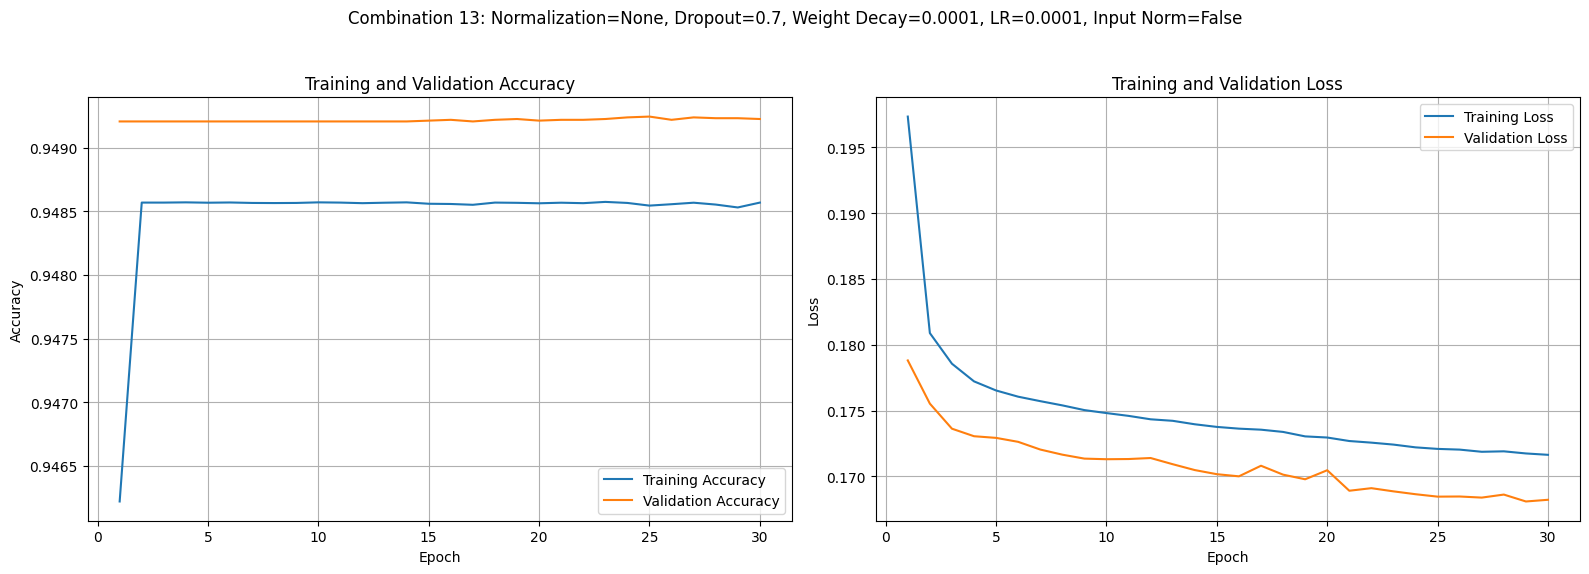

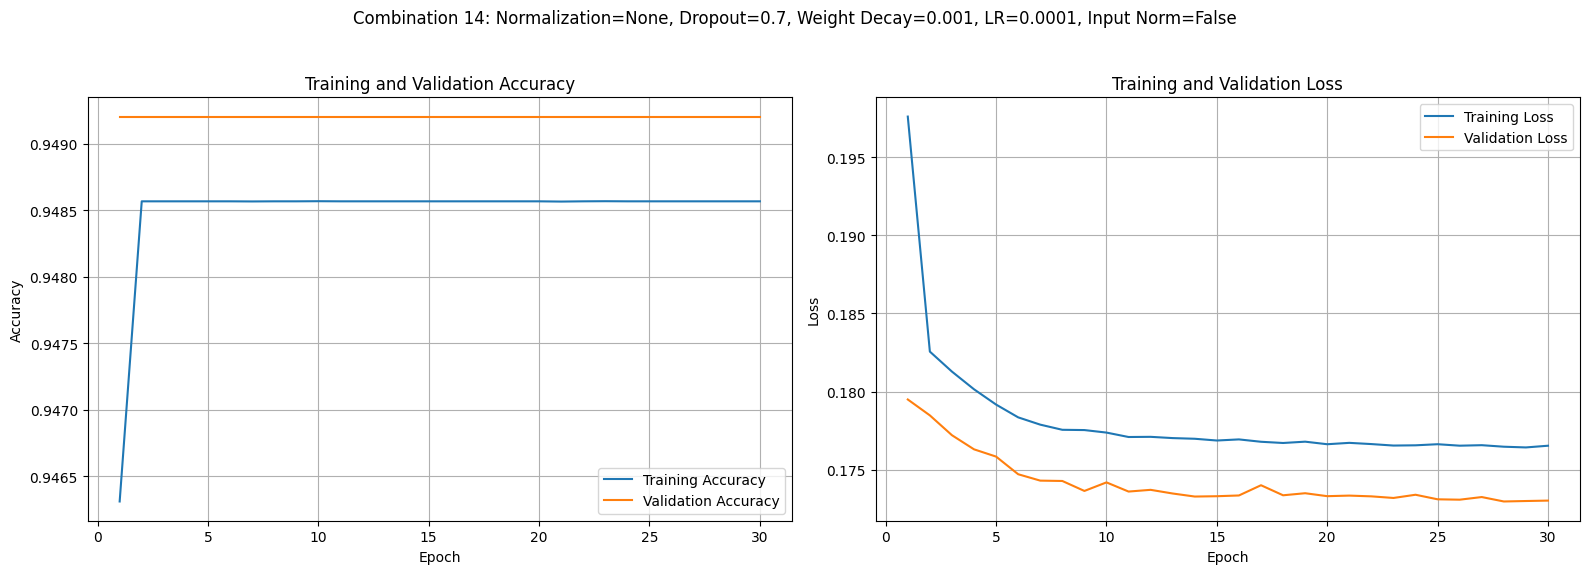

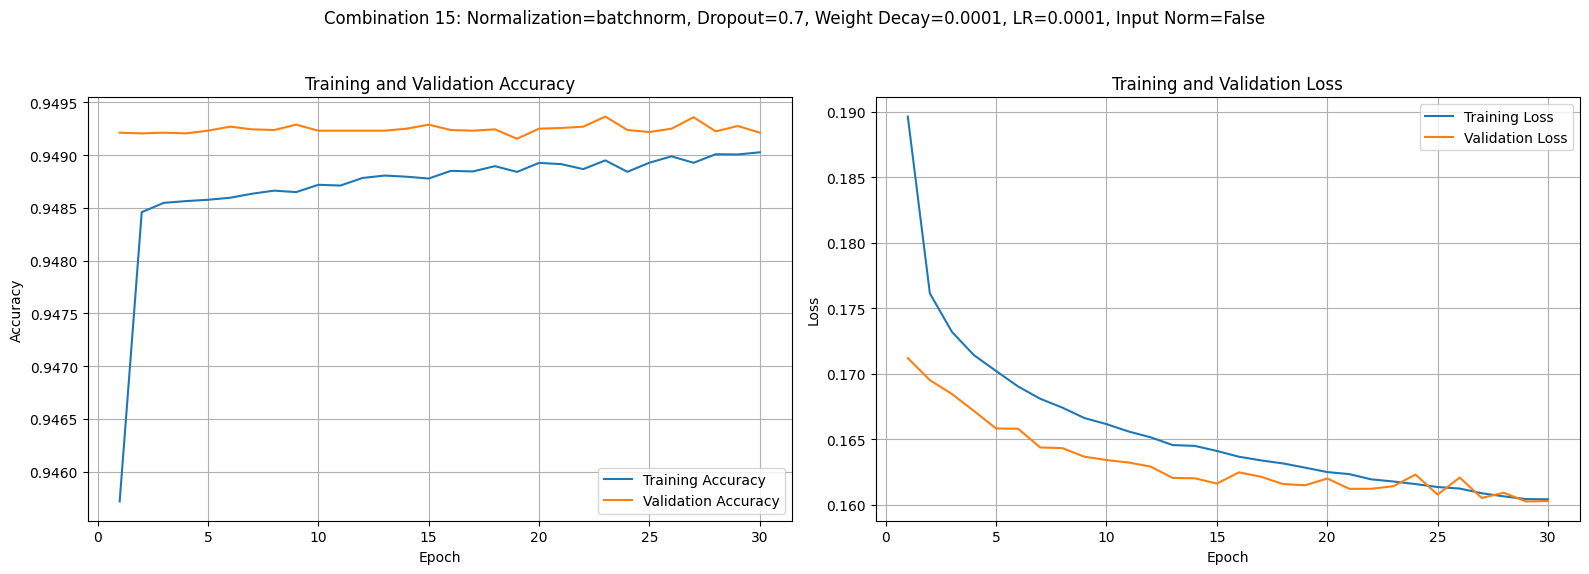

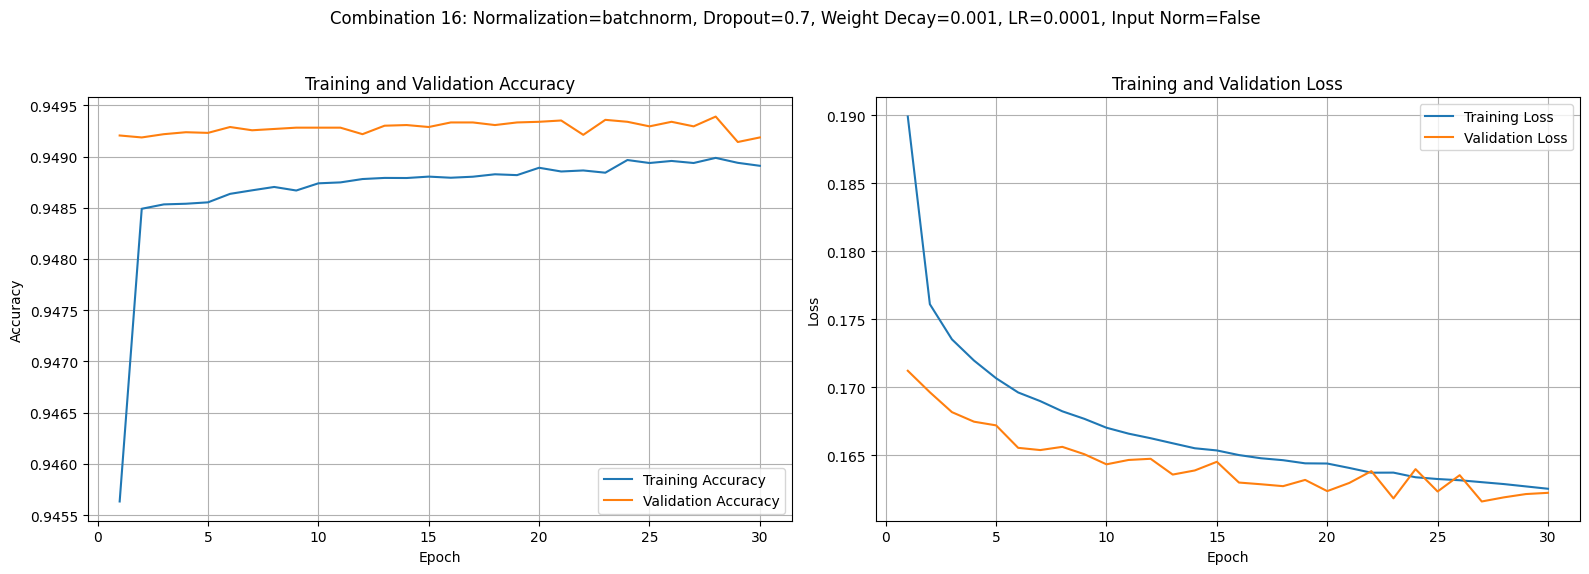

Generated training and validation curves for all hyperparameter combinations.


In [ ]:
import matplotlib.pyplot as plt

# Assuming num_epochs is already defined from previous steps
# num_epochs = 30

for i, result in enumerate(all_results):
    hyperparameters = result['hyperparameters']
    train_losses = result['train_losses']
    train_accuracies = result['train_accuracies']
    val_losses = result['val_losses']
    val_accuracies = result['val_accuracies']

    epochs = range(1, num_epochs + 1)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Training and Validation Accuracy
    ax1.plot(epochs, train_accuracies, label='Training Accuracy')
    ax1.plot(epochs, val_accuracies, label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot Training and Validation Loss
    ax2.plot(epochs, train_losses, label='Training Loss')
    ax2.plot(epochs, val_losses, label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()
    ax2.grid(True)

    # Set a title for the entire figure showing hyperparameters
    fig.suptitle(
        f"Combination {i+1}: Normalization={hyperparameters['normalization']}, "
        f"Dropout={hyperparameters['dropout']}, Weight Decay={hyperparameters['weight_decay']}, "
        f"LR={hyperparameters['learning_rate']}, Input Norm={hyperparameters['input_normalization']}"
    )

    # Adjust layout to prevent overlapping titles/labels
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("Generated training and validation curves for all hyperparameter combinations.")